
<img src=https://www.nersc.gov/_resources/themes/nersc/images/NERSC_logo_no_spacing.svg width="500">

### National Energy Research Scientific Computing Center
#### Introduction to High Performance Computing Bootcamp 2025

# Parallel Computing

**Parallel computing** is a method of computation in which many calculations or processes are carried out simultaneously.  
Instead of solving a problem sequentially on a single processor, we **divide the work** into smaller, independent (or partially independent) tasks that can run at the same time on multiple processors.  

These processors might:
- Share the same memory space (shared-memory systems)
- Communicate via a high-speed interconnect (distributed-memory systems)
- Use a hybrid model combining both approaches

The goal is to **reduce total execution time**, **solve larger problems**, or **achieve more accurate results** within the same time window.

In high-performance computing (HPC), parallel computing is critical because:
- Modern supercomputers contain **thousands to millions of processing elements**.
- Many scientific problems—like weather forecasting, molecular modeling, or climate simulations—are simply too large to be computed in a reasonable time using serial methods.
- Efficient parallelization directly impacts both performance and energy efficiency.

---

## Monte Carlo π Example

One simple but illustrative application of parallel computing is estimating the mathematical constant **π** using the **Monte Carlo method**.

### Concept
The Monte Carlo method uses **random sampling** to solve numerical problems.  
In this case, we:
1. Generate random points inside a square of side length \( 2r \).
2. Count how many points fall inside the quarter of a circle of radius \( r \) that fits within that square.
3. Use geometry to relate the fraction of points inside the quarter circle to the value of π.

**The ratio of the areas is:**

$$
\frac{N_{\mathrm{in}}}{N_{\mathrm{total}}}
=\frac{\pi r^2}{4r^2}
=\frac{\pi}{4}
$$

**Rearranging gives:**

$$
\pi \approx \frac{4\,N_{\mathrm{in}}}{N_{\mathrm{total}}}
$$


---

### Why Parallelize It?
The Monte Carlo method requires **a large number of random samples** for good accuracy.  
If we split the work across multiple processors:
- Each processor generates its own set of random points and counts how many land inside the circle.
- The counts from all processors are **combined** to compute the final π estimate.
- The workload is perfectly parallelizable because each processor’s calculation is **independent**—no communication is required until the final sum.

This makes it a great example for:
- Learning **MPI (Message Passing Interface)** basics.
- Understanding how **data parallelism** works in HPC.
- Demonstrating how scaling up the number of processors can reduce computation time while maintaining accuracy.

---

### Visual Intuition
![PI](https://www.101computing.net/wp/wp-content/uploads/estimating-pi-monte-carlo-method.png)

In the image above:
- The square represents the total sampling area.
- The quarter circle (red curve) is the target region for counting points.
- The more random points we generate, the closer our estimate of π will get to the actual value.

---

### DOE HPC Bootcamp Context
At the DOE HPC Bootcamp, this π example is not about pushing the limits of computational mathematics—it’s about providing a **safe, simple playground** for learning parallel programming concepts.  
The Monte Carlo π problem:
- Has a **clear, visual outcome** that makes it easy to validate results.
- Allows you to **focus on MPI communication patterns** without getting lost in complex scientific code.
- Can be run on **any scale**—from your laptop to a full HPC cluster—making it ideal for demonstrating how problem size and processor count affect runtime and scaling.
  
By mastering the fundamentals here, you’ll be better prepared to apply the **same parallel computing strategies** to DOE-scale workloads like **molecular dynamics simulations, computational fluid dynamics (CFD), and climate modeling**, where parallel efficiency directly impacts both scientific discovery and operational costs.

---


---

### Visualizing π – The Monte Carlo Way (a.k.a. Throwing Darts for Science)


Lets **watch π come to life**.

You’ve read about the Monte Carlo method for estimating π, but there’s something magical about *seeing* the process unfold.  
In this interactive visualization, we’ll simulate the act of throwing darts at a square dartboard with a quarter circle inside.  
Every dart that lands **inside** the circle gets a red dot.  
Every dart that lands **outside** the circle gets a blue dot.  

As the simulation runs:
- The **red-to-blue ratio** starts off wobbly and uncertain.
- But as we throw more and more darts, the estimate of π begins to **settle down** toward the real value (3.1415…).
- You’ll see the estimate update live, along with a count of how many darts hit inside vs total thrown.

Why are we doing this in an HPC Bootcamp?
- It’s a **perfect parallel computing candidate**—every dart throw is independent and could be done on a separate processor.
- The logic is simple enough that you can focus on the *parallelization*, not the math.
- It’s a great way to see how randomness and statistics converge to produce accurate results over time.

Think of it as:
> *"Parallel computing meets carnival game—with the prize being π itself."*

By the end, you’ll have:
- A visual intuition for how Monte Carlo estimation works.
- A foundation for splitting the workload across multiple processors with MPI.
- The satisfaction of having calculated π without ever touching a trigonometric function.

Pro tip: The more darts you throw, the better your aim… statistically speaking. 🎯

---


Pi = 3.192
Time: 48.830957651138306


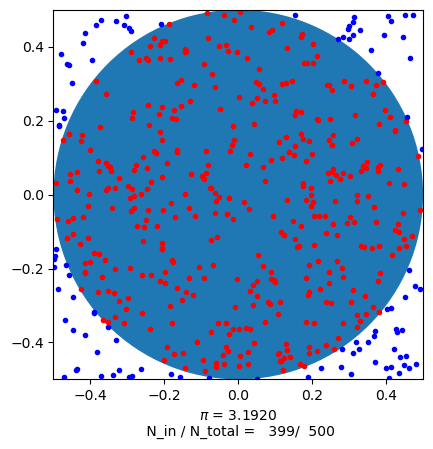

In [1]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import random
import time
fig, ax = plt.subplots()
#ax = fig.add_subplot(111)
circle = plt.Circle(( 0. , 0. ), 0.5 )
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
ax.add_patch(circle)
ax.set_aspect('equal')
N = 500
Nin = 0
t0 = time.time()
for i in range(1, N+1):
    x = random.uniform(-0.5, 0.5)
    y = random.uniform(-0.5, 0.5)
    if (np.sqrt(x*x + y*y) < 0.5):
        Nin += 1
        plt.plot([x], [y], 'o', color='r', markersize=3)
    else:
        plt.plot([x], [y], 'o', color='b', markersize=3)
    display(fig)
    plt.xlabel("$\pi$ = %3.4f \n N_in / N_total = %5d/%5d" %(Nin*4.0/i, Nin, i))
    clear_output(wait=True)

res = np.array(Nin, dtype='d')
t1 = time.time()
print(f"Pi = {res/float(N/4.0)}")
print("Time: %s" %(t1 - t0))

### MPI Pi example

Before implementing our method of Darts examples, lets work through a python example of pi.

Below, you will find:

1) myPi.py - python implementation
2) myPi_jobscript(1-3).sh for submitting a batch submission on perlmutter
3) submit and stream subprocess for displaying batch submission results
4) submission block for submitting a batch job

In [1]:
# %%writefile myPi.py

# example of python implementation of Pi with mpi4py
from mpi4py import MPI
import numpy as np
import random
import time
comm = MPI.COMM_WORLD

N = 5000000
Nin = 0
t0 = time.time()
for i in range(comm.rank, N, comm.size):
    x = random.uniform(-0.5, 0.5)
    y = random.uniform(-0.5, 0.5)
    if (np.sqrt(x*x + y*y) < 0.5):
        Nin += 1
res = np.array(Nin, dtype='d')
res_tot = np.array(Nin, dtype='d')
comm.Allreduce(res, res_tot, op=MPI.SUM)
t1 = time.time()
if comm.rank==0:
    print(res_tot/float(N/4.0))
    print("Time: %s" %(t1 - t0))

3.1426496
Time: 6.4136576652526855


In [2]:
import subprocess, time, os, sys

def submit_and_stream(script_path: str, poll_seconds: float = 1.0):
    """
    Submit a Slurm batch script with sbatch, stream stdout to this notebook
    as the slurm-<jobid>.out file grows, and print a brief completion summary.
    """
    # Submit
    submit_out = subprocess.check_output(["sbatch", script_path]).decode().strip()
    jobid = submit_out.split()[-1]
    print(f"Submitted job {jobid}\n")

    outfile = f"slurm-{jobid}.out"
    last_size = 0

    while True:
        if os.path.exists(outfile):
            with open(outfile, "r") as f:
                f.seek(last_size)
                chunk = f.read()
                if chunk:
                    sys.stdout.write(chunk)
                    sys.stdout.flush()
                last_size = f.tell()

        try:
            still_running = bool(
                subprocess.check_output(["squeue", "-h", "-j", jobid]).decode().strip()
            )
        except Exception:
            still_running = True

        if not still_running:
            if os.path.exists(outfile):
                with open(outfile, "r") as f:
                    f.seek(last_size)
                    rest = f.read()
                    if rest:
                        sys.stdout.write(rest)
                        sys.stdout.flush()
            break

        time.sleep(poll_seconds)

    try:
        summary = subprocess.check_output(
            ["sacct", "-j", jobid, "--format=JobID,State,ExitCode", "-n", "-P"]
        ).decode().strip()
        print("\n--- Job summary ---")
        print(summary)
    except Exception:
        pass


In [3]:
%%writefile myPi_jobscript.sh
#!/bin/bash
#SBATCH --qos=debug
#SBATCH --time=2
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH -C cpu 
#SBATCH -A m4388

srun python myPi.py

Overwriting myPi_jobscript.sh


In [ ]:
%%writefile myPi_jobscript.sh
#!/bin/bash
#SBATCH --qos=debug
#SBATCH --time=2
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=2
#SBATCH -C cpu 
#SBATCH -A m4388

srun python myPi.py

In [5]:
%%writefile myPi_jobscript.sh
#!/bin/bash
#SBATCH --qos=shared
#SBATCH --time=2
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=4
#SBATCH -C cpu 
#SBATCH -A m4388

srun python myPi.py

Overwriting myPi_jobscript.sh


### Submitting a Job on Perlmutter
To submit the job, run the following command:
"sbatch myPi_jobscript.sh"
or you may use the submit_and_stream method, which will display the output in the notebook.

In [6]:
!sbatch myPi_jobscript.sh

Submitted batch job 41532985


In [4]:
submit_and_stream("myPi_jobscript.sh", poll_seconds=1.0)

Submitted job 41572191

3.1411856
Time: 5.146117448806763

--- Job summary ---
41572191|COMPLETED|0:0
41572191.batch|COMPLETED|0:0
41572191.extern|COMPLETED|0:0
41572191.0|COMPLETED|0:0


## Parallel computing in AI
The parallel computing in AI is usually called distributed training. Distributed training is the process of training I models across multiple GPUs or other accelerators, with the goal of speeding up the training process and enabling the training of larger models on larger datasets.

There are two ways of parallelization in distributed training. 
* **Data parallelism**: 
    * Each worker (GPU) has a complete set of model
    * different workers work on different subsets of data. 
* **Model parallelism** 
    * The model is splitted into different parts and stored on different workers
    * Different workers work on computation involved in different parts of the model
![Perlmutter](https://docs.nersc.gov/systems/perlmutter/images/PerlmutterCabinetsFinal.jpg)

In [3]:
!sbatch myPiDarts_jobscript.sh

Submitted batch job 41535322


# Estimating π with the "Method of Darts"

The **method of darts** is a Monte Carlo simulation that estimates π by randomly "throwing darts" at a square target that contains a quarter circle.  

If you throw darts uniformly at random:

- The fraction that land **inside** the quarter circle is proportional to its area.
- Since the area of a quarter circle of radius 1 is π/4,  
  \[
    \pi \approx 4 \times \frac{\text{# darts inside}}{\text{total darts}}
  \]

---

## Concept Diagram

<img src="https://upload.wikimedia.org/wikipedia/commons/8/84/Pi_30K.gif" 
     alt="Monte Carlo darts method animation" width="400">

*Above: simulation showing points inside (red) and outside (blue) the quarter circle.*

---

## Parallel Implementation with MPI

In our MPI version:

1. **Partition:** Each MPI rank throws a subset of the total darts.
2. **Computation:** Each rank counts how many darts land inside the circle.
3. **Communication:** The counts are sent to **rank 0** using `MPI.Reduce`.
4. **Aggregation:** Rank 0 sums the counts and computes π.

---

### Example Run

In [6]:
%%writefile myPiDarts.py
# Monte Carlo "method of darts" to estimate π
# Works in serial AND with MPI (mpi4py). If you launch with mpirun/srun, it will parallelize.
# In Jupyter, this cell still runs fine with a single rank.

from __future__ import annotations
import math
import numpy as np

try:
    from mpi4py import MPI
    COMM = MPI.COMM_WORLD
    RANK = COMM.Get_rank()
    SIZE = COMM.Get_size()
except Exception:  # mpi4py not available; fall back to serial
    COMM = None
    RANK = 0
    SIZE = 1

def darts_inside_circle(n: int, seed: int | None = None) -> int:
    """
    Throw n 'darts' uniformly at the unit square [0,1]x[0,1] and
    count how many land inside the quarter circle x^2 + y^2 <= 1.
    Vectorized for speed.
    """
    # Make each rank reproducible but distinct
    if seed is not None:
        # Use SeedSequence to derive independent per-rank seeds
        ss = np.random.SeedSequence(seed)
        child_ss = ss.spawn(1 if SIZE == 1 else SIZE)[RANK]
        rng = np.random.default_rng(child_ss)
    else:
        rng = np.random.default_rng()

    x = rng.random(n)
    y = rng.random(n)
    return np.count_nonzero(x*x + y*y <= 1.0)

def estimate_pi(n_samples: int, seed: int | None = 12345) -> tuple[float, int, int]:
    """
    Estimate π using the Monte Carlo 'darts' method.
    Each rank throws n_samples/SIZE darts (last rank gets the remainder).
    Returns (pi_estimate, local_inside, global_inside) on rank 0;
    on other ranks, returns (np.nan, local_inside, 0) for convenience.
    """
    # Divide the work as evenly as possible across ranks
    base = n_samples // SIZE
    rem = n_samples % SIZE
    local_n = base + (1 if RANK < rem else 0)

    local_inside = darts_inside_circle(local_n, seed=seed)

    if COMM is not None:
        global_inside = COMM.reduce(local_inside, op=MPI.SUM, root=0)
        global_total = COMM.reduce(local_n,      op=MPI.SUM, root=0)
    else:
        global_inside = local_inside
        global_total = local_n

    if RANK == 0:
        pi_hat = 4.0 * (global_inside / float(global_total))
        return pi_hat, local_inside, global_inside
    else:
        return float("nan"), local_inside, 0

# --- Configure and run ---
# Feel free to turn this up to 10_000_000+ when running on multiple ranks
N_SAMPLES = 2_000_000
SEED = 2025

pi_hat, local_inside, global_inside = estimate_pi(N_SAMPLES, seed=SEED)

if RANK == 0:
    rel_err = abs(pi_hat - math.pi) / math.pi
    print(f"Ranks: {SIZE}")
    print(f"Total darts: {N_SAMPLES:,}")
    print(f"Estimated π: {pi_hat:.8f}")
    print(f"Actual    π: {math.pi:.8f}")
    print(f"Relative error: {rel_err:.3e}")


Writing myPiDarts.py


In [7]:
%%writefile myPiDarts_jobscript.sh
#!/bin/bash
#SBATCH --qos=debug
#SBATCH --time=2
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=8
#SBATCH -C cpu 
#SBATCH -A m4388

srun python myPiDarts.py

Overwriting myPiDarts_jobscript.sh


In [7]:
import subprocess, time, os, sys

def submit_and_stream(script_path: str, poll_seconds: float = 1.0):
    """
    Submit a Slurm batch script with sbatch, stream stdout to this notebook
    as the slurm-<jobid>.out file grows, and print a brief completion summary.
    """
    # Submit
    submit_out = subprocess.check_output(["sbatch", script_path]).decode().strip()
    jobid = submit_out.split()[-1]
    print(f"Submitted job {jobid}\n")

    outfile = f"slurm-{jobid}.out"
    last_size = 0

    while True:
        if os.path.exists(outfile):
            with open(outfile, "r") as f:
                f.seek(last_size)
                chunk = f.read()
                if chunk:
                    sys.stdout.write(chunk)
                    sys.stdout.flush()
                last_size = f.tell()

        try:
            still_running = bool(
                subprocess.check_output(["squeue", "-h", "-j", jobid]).decode().strip()
            )
        except Exception:
            still_running = True

        if not still_running:
            if os.path.exists(outfile):
                with open(outfile, "r") as f:
                    f.seek(last_size)
                    rest = f.read()
                    if rest:
                        sys.stdout.write(rest)
                        sys.stdout.flush()
            break

        time.sleep(poll_seconds)

    try:
        summary = subprocess.check_output(
            ["sacct", "-j", jobid, "--format=JobID,State,ExitCode", "-n", "-P"]
        ).decode().strip()
        print("\n--- Job summary ---")
        print(summary)
    except Exception:
        pass


In [8]:
submit_and_stream("myPiDarts_jobscript.sh", poll_seconds=1.0)

Submitted job 41572235

Ranks: 4
Total darts: 2,000,000
Estimated π: 3.14075200
Actual    π: 3.14159265
Relative error: 2.676e-04

--- Job summary ---
41572235|COMPLETED|0:0
41572235.batch|COMPLETED|0:0
41572235.extern|COMPLETED|0:0
41572235.0|COMPLETED|0:0
